In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, MaxPooling2D, GlobalMaxPool2D, Conv2D, Conv2DTranspose, concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
## Seeding
seed = 2019
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Converting the image into the desired form
def load_image(img_path, show=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128,128))
    img_tensor = img_to_array(img)
    #img_tensor = np.expand_dims(img_tensor, axis=0)

    return img_tensor

In [ ]:
!unzip -u "/content/drive/MyDrive/salt_dataset.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/salt_dataset/train/images/bf76c8aff3.png  
  inflating: /content/salt_dataset/train/images/bfa7ee102e.png  
  inflating: /content/salt_dataset/train/images/bfac8e63cb.png  
  inflating: /content/salt_dataset/train/images/bfb0e22b53.png  
  inflating: /content/salt_dataset/train/images/bfbb9b9149.png  
  inflating: /content/salt_dataset/train/images/bfbea83faa.png  
  inflating: /content/salt_dataset/train/images/bfc47bbe13.png  
  inflating: /content/salt_dataset/train/images/bfcd0fb5ac.png  
  inflating: /content/salt_dataset/train/images/bfd1d7caa1.png  
  inflating: /content/salt_dataset/train/images/c00c4b8814.png  
  inflating: /content/salt_dataset/train/images/c02071548b.png  
  inflating: /content/salt_dataset/train/images/c023a62b96.png  
  inflating: /content/salt_dataset/train/images/c026a17632.png  
  inflating: /content/salt_dataset/train/images/c038f6fbe4.png  
  inflating: /content/salt_dataset/trai

In [ ]:
x = []
y = []

def get_image(path):
    data =[]
    for subdir, dirs, files in os.walk(path):
        for f in files:
            path = os.path.join(subdir, f)
            img = load_image(path)
            print(img.shape)
            img = img/255.0
            data.append(img)
    return data


x = get_image(r'/content/salt_dataset/train/images')
y = get_image(r'/content/salt_dataset/train/masks')

x = np.asarray(x)
y = np.asarray(y)


Streaming output truncated to the last 5000 lines.
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 

In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, random_state=42)

In [ ]:
print(x.shape)
print(y.shape)

(4000, 128, 128, 1)
(4000, 128, 128, 1)


Text(0.5, 1.0, 'Salt')

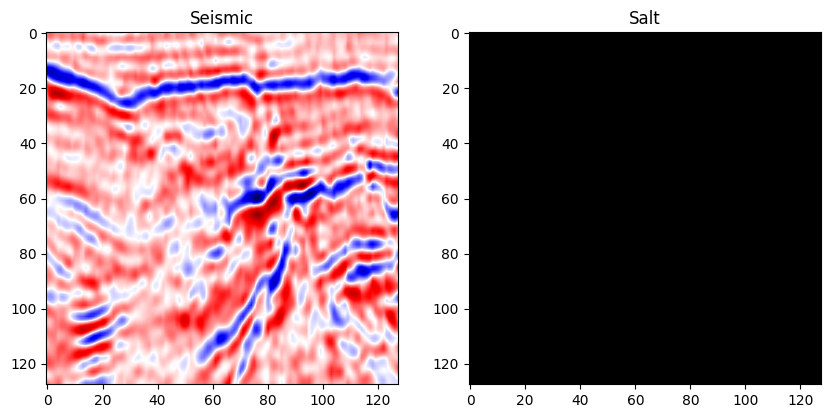

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [ ]:
def UNet(input_img):

    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_img)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)

    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)

    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
#-----------------------------------------------------------------------------------------------------------------

    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)

    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)

    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)
#-----------------------------------------------------------------------------------------------------------------

    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3)

#-----------------------------------------------------------------------------------------------------------------

    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.1)(p4)

#-----------------------------------------------------------------------------------------------------------------

    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

#------UMSAMPLE STARTS---------------------------------------------------------------------------------------------

    u6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)

    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

#---------------------------------------------------------------------------------------------------

    u7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)

    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

#---------------------------------------------------------------------------------------------------

    u8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)

    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

#---------------------------------------------------------------------------------------------------

    u9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)

    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)

    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)


    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)



    model = Model(input_img, outputs)
    return model

In [ ]:
input_img = Input((128, 128, 1), name='img')
model = UNet(input_img)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['img[0][0]']                 
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [ ]:
#Using EarlyStopping to stop the training if the algorithm is not converging,
#ReduceLROnPlateau to change the learning rate in runtime if the algorithm is not converging,
#ModelCheckpoint to save the model time to time whenever there is a imporvement
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/model_salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
# train the network
history = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.0627 - acc: 0.9731
Epoch 1: val_loss did not improve from 0.13278
113/113 [==============================] - 15s 130ms/step - loss: 0.0627 - acc: 0.9731 - val_loss: 0.1417 - val_acc: 0.9459 - lr: 1.0000e-05
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.0627 - acc: 0.9731
Epoch 2: val_loss did not improve from 0.13278
113/113 [==============================] - 15s 133ms/step - loss: 0.0627 - acc: 0.9731 - val_loss: 0.1429 - val_acc: 0.9457 - lr: 1.0000e-05
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 0.0625 - acc: 0.9733
Epoch 3: val_loss did not improve from 0.13278
113/113 [==============================] - 15s 133ms/step - loss: 0.0625 - acc: 0.9733 - val_loss: 0.1431 - val_acc: 0.9456 - lr: 1.0000e-05
Epoch 4/50
113/113 [==============================] - ETA: 0s - loss: 0.0619 - acc: 0.9733
Epoch 4: val_loss did not improve from 0.13278
113/113 [================

In [ ]:
model.save(r'/content/model_salt.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate(X_valid,y_valid)

13/13 [==============================] - 0s 31ms/step - loss: 0.1451 - acc: 0.9456


[0.14512529969215393, 0.9455999732017517]

In [ ]:
# Print available keys in the history object
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


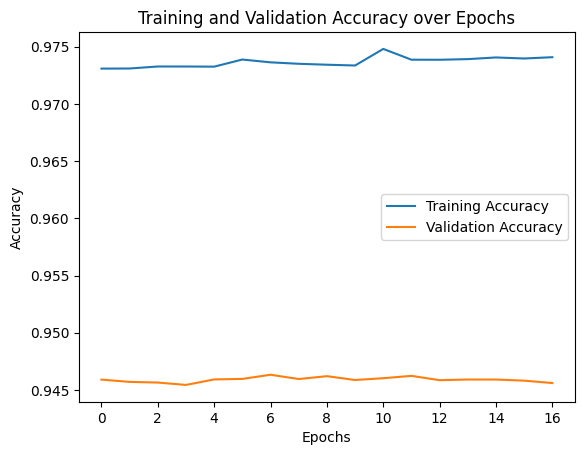

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

# Save and display the plot
plt.savefig('unet.png')
plt.show()

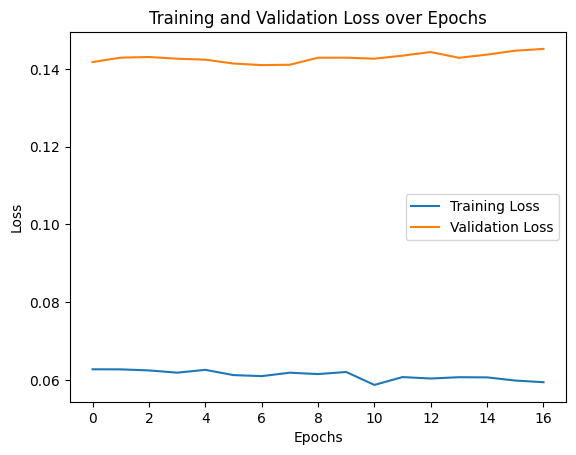

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Save and display the plot
plt.savefig('unet.png')
plt.show()

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

13/13 [==============================] - 0s 24ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:

def plot_sample(X, y, preds, binary_preds):
    ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    #X[ix, ..., 0] changes the dimensions of X please print it and see
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

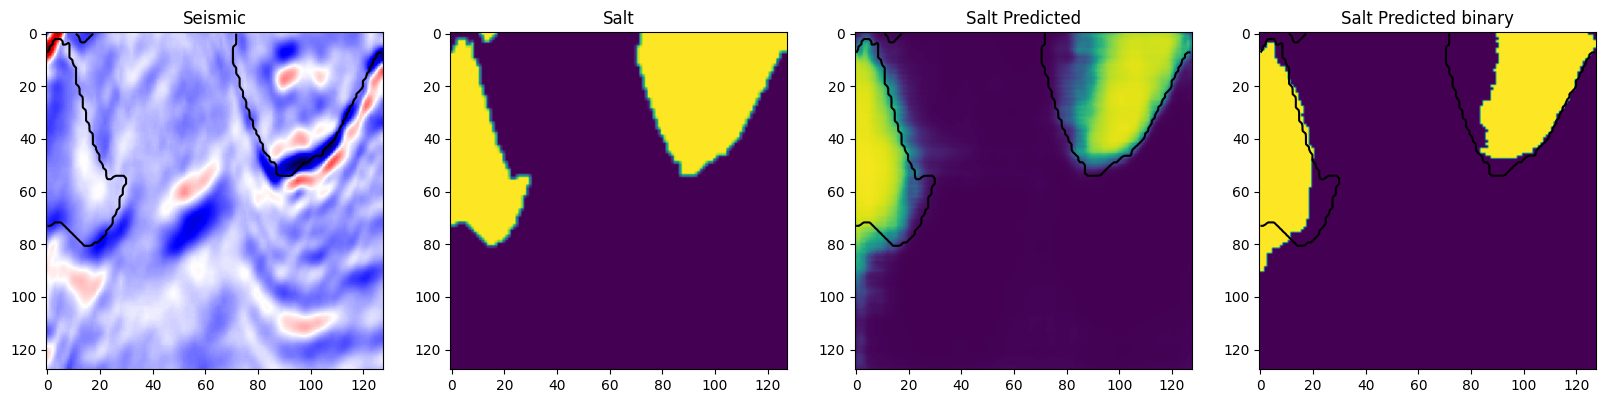

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

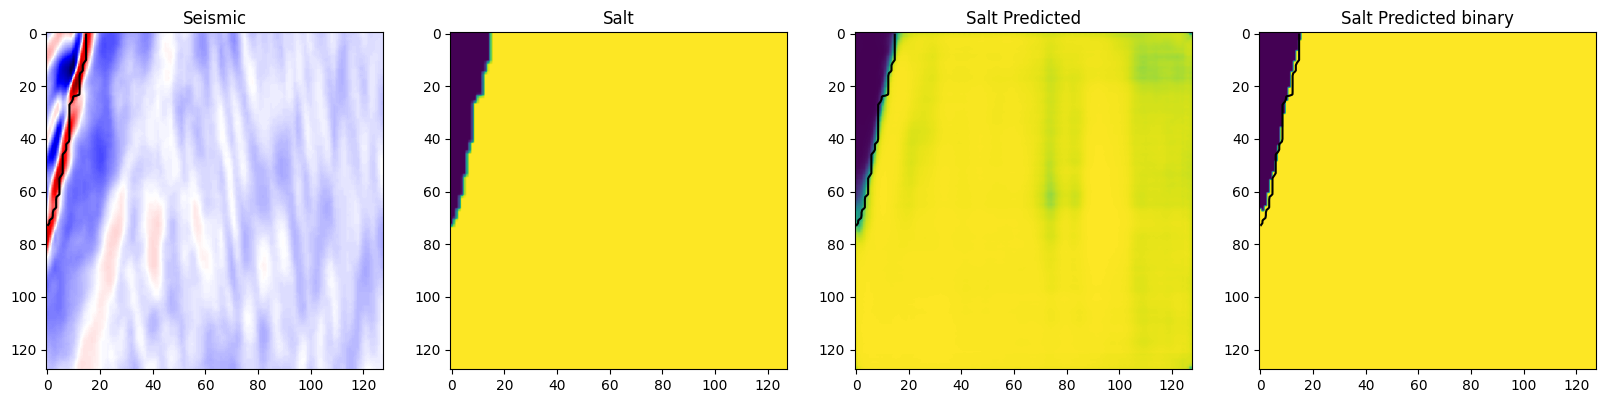

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)